In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import astropy
from astropy.io import fits
from astropy.stats import sigma_clip
from numpy.random import randn
from numpy import mean
from numpy import ma
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reject_outliers(data, m=2):
    #print(data)
    #print(' ')
    stdev = np.nanstd(data)
    mean = np.nanmean(data)
    median = np.nanmedian(data)
    Min = median - stdev * m
    Max = median + stdev * m
    #print(Min, Max)
    for p, point in enumerate(data):
        if point < Min: data[p]=np.nan
        if point > Max: data[p]=np.nan
    #print(data)
    #print(' ')
    return data

In [3]:
zeropoints=[17.38, 16.85, 17.44, 18.34, 19.11, 17.89]

# -2.5 log (cr) + zp = mag
print("mag 20")
for zeropoint in zeropoints:
    print(10**((zeropoint-20)/2.5))
print("mag 15")
for zeropoint in zeropoints:
    print(10**((zeropoint-15)/2.5))

print("we want to use stars with count rates between 0.1ish to 50ish to measure aperture correction")


mag 20
0.08953647655495928
0.05495408738576254
0.0946237161365794
0.21677041048196946
0.4405548635065531
0.14321878992735443
mag 15
8.95364765549593
5.495408738576252
9.462371613657941
21.67704104819694
44.0554863506553
14.321878992735439


In [4]:
filters=['vv','bb','uu','w1','m2','w2']


flatapcor=[1.086,1.086,1.10,1.11,1.12,1.15]
apcorflat=[1.086,1.086,1.10,1.11,1.12,1.15]

comps=['1','2','3','4','5','6','7','8','9']#,'01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35']
# 36-40 have been removed so they can be used for galaxy contaminated comparison stars but not aperture corrections

binfields=['SN2005df','SN2006X','SN2006E','WD1026','WD1121','WD1657'] 
fields=binfields

print("fields used in the following: ", fields)

['SN2005df', 'SN2006X', 'SN2006E', 'WD1026', 'WD1121', 'WD1657']


In [ ]:
colors=['#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a']
#centroidcolors=['#73a2c6', '#f4777f', '#93003a','#00429d']
#colors=['blue','green', 'red', 'purple']
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.style.use('classic')

In [5]:

mostepochs=300
mostcomps=len(comps)


mostfilters=6
mostfields=len(fields)

cr3 =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr3e=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5 =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5e=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')

cr3_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr3e_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
cr5e_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')

apcor_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
apcore_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
apcor =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
apcore=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
       
year =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
exposure=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
telapse =np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
bkg=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')

bin=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')
bin_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs),dtype='float')

year[:] = np.nan
exposure[:] = np.nan
telapse[:] = np.nan
bkg[:] = np.nan
bin[:] = np.nan
bin_centroid[:] = np.nan


        
cr3[:] = np.nan
cr3e[:] = np.nan
cr5[:] = np.nan
cr5e[:] = np.nan
        
cr3_centroid[:] = np.nan
cr3e_centroid[:] = np.nan
cr5_centroid[:] = np.nan
cr5e_centroid[:] = np.nan


apcor[:] = np.nan
apcore[:] = np.nan
        
apcor_centroid[:] = np.nan
apcore_centroid[:] = np.nan


frameapcor=np.empty((mostfilters, mostfields,mostepochs))
frameapcor[:] = np.nan
frameapcorscat=np.empty((mostfilters, mostfields,mostepochs))
frameapcorscat[:] = np.nan

compapcor=np.empty((mostfilters, mostfields,mostcomps))
compapcor[:] = np.nan

compapcorscat=np.empty((mostfilters, mostfields,mostcomps))
compapcorscat[:] = np.nan


for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[flatapcor[index],flatapcor[index]]    
    for j, field in enumerate(fields):
        #print(field)
        fieldindex=fields.index(field)
        #if index==1: 
            #ax.text(57000, 1.35-fieldindex*0.05, field, fontsize=12, color=colors[fieldindex])

        for c, comp in enumerate(comps):
            #print(" ")
            #print("comp ",int(comp))
            file        ='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'bin_more.dat'
            filecentroid='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_centroidbin_more.dat'
            if os.path.exists(file):
                f = open(file, 'r')
                #print(file)
                for e, line in enumerate(f):
                    #print( x, y)
                    #print(line)
                    columns=line.split()
                    #print(field, comp)
                    #print(columns)
                    #print(columns[0],columns[1])                    
                    # columns[1] isn't parsed right but this seems to work
                    
                    #if float(columns[7])/float(columns[8]) >5:
                        
                    year[i,j,c,e]=columns[1]
                    exposure[i,j,c,e]=columns[2]
                    telapse[i,j,c,e]=columns[3]

                    cr3[i,j,c,e]=columns[4]
                    cr3e[i,j,c,e]=columns[5]
                    bkg[i,j,c,e]=columns[6]
                    cr5[i,j,c,e]=columns[7]
                    cr5e[i,j,c,e]=columns[8]
                    bin[i,j,c,e]=columns[9]
                    #apcor[i,j,c,e]=cr5[i,j,c,e]/cr3[i,j,c,e]
                    #apcore[i,j,c,e]=((cr5e[i,j,c,e]/cr5[i,j,c,e])**2.0+(cr3e[i,j,c,e]/cr3[i,j,c,e])**2.0)**0.5*apcor[i,j,c,e]
                    #print, filter, field, comp, e, apcor[i,j,c,e], apcore[i,j,c,e]
                if np.median(cr5[i,j,c,:])>150:cr5[i,j,c,:]=np.nan
                
                
                cr5[cr3<0]=np.nan
                # clean out outliers from the same epoch
                datatoclean=cr5[i,j,c,:]
                cleaneddata=reject_outliers(datatoclean, m=2)
                
                
            if os.path.exists(filecentroid):
                f = open(filecentroid, 'r')
                #print(file)
                for e, line in enumerate(f):
                    columns=line.split()

                    cr3_centroid[i,j,c,e]=columns[4]
                    cr3e_centroid[i,j,c,e]=columns[5]
                    cr5_centroid[i,j,c,e]=columns[7]
                    cr5e_centroid[i,j,c,e]=columns[8]
                    bin_centroid[i,j,c,e]=columns[9]
                    apcor_centroid[i,j,c,e]=cr5[i,j,c,e]/cr3[i,j,c,e]
                    apcore_centroid[i,j,c,e]=((cr5e[i,j,c,e]/cr5[i,j,c,e])**2.0+(cr3e[i,j,c,e]/cr3[i,j,c,e])**2.0)**0.5*apcor[i,j,c,e]
                              
                    #print(field,' ',filter,'comp ',comp,'epoch ',e,' apcor ', apcor_centroid[i,j,c,e], 'apcor error', apcore_centroid[i,j,c,e], 'centroided fraction', np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]))
                #print("Ap 5 count rates")
                #print(cr5[i,j,c,:])
                #print("Ap Cor mean for Comp ",c+1)
                #print(c)
                #data=cr5[i,j,c,:]
                #reject_outliers(data, m=2)
                #cr5[i,j,c,:]=data
                compapcor[i,j,c]=np.nanmean(np.divide(cr5[i,j,c,:],cr3[i,j,c,:]))
                #print(compapcor[i,j,c])

                compapcorscat[i,j,c]=np.nanstd(np.divide(cr5[i,j,c,:],cr3[i,j,c,:]))
                #print("Ap Cor scat for Comp ",c+1)
                #print(compapcorscat[i,j,c])


                f.close()

        cr3=np.array(cr3, dtype=np.float32)
        cr5=np.array(cr5, dtype=np.float32)
        cr3e=np.array(cr3e, dtype=np.float32)
        cr5e=np.array(cr5e, dtype=np.float32)

        cr3[cr3/cr3e<5]=np.nan
        cr5[cr5/cr5e<5]=np.nan
        
        
        for e in range(0,len(frameapcor[i,j,:])-2):
            #print(" ")
            #print(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))
            frameapcor[i,j,e]   =np.nanmean(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))
            frameapcorscat[i,j,e]=np.nanstd(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))

frameapcor=np.array(frameapcor, dtype=np.float32)

frameapcorscat=np.array(frameapcorscat, dtype=np.float32)

compapcor=np.array(compapcor, dtype=np.float32)

compapcorscat=np.array(compapcorscat, dtype=np.float32)


apcor=cr5/cr3
#apcore=((cr5e/cr5)**2.0+(cr3e/cr3)**2.0-2*cr3e/cr5*cr3*cr5e/cr5/cr5*0.9)**0.5
apcore=(cr5e/cr5)

 # https://www2.census.gov/programs-surveys/acs/tech_docs/accuracy/2020_ACS_Accuracy_Document_Worked_Examples.pdf                   
                    
print(" ")           
                    
                    


vv
bb
uu
w1
m2
w2
 


In [6]:
# S/N cut
apcor[cr3/cr3e<5]=np.nan
apcore[cr3/cr3e<5]=np.nan
apcor[cr3<0]=np.nan
apcore[cr3<0]=np.nan

apcor_centroid[cr3/cr3e<5]=np.nan
apcore_centroid[cr3/cr3e<5]=np.nan
apcor_centroid[cr3<0]=np.nan
apcore_centroid[cr3<0]=np.nan

# high error cut

apcor[apcore>0.2]=np.nan
apcore[apcore>0.2]=np.nan

apcor_centroid[apcore>0.2]=np.nan
apcore_centroid[apcore>0.2]=np.nan



In [7]:
apcor[cr3<0]=np.nan
apcore[cr3<0]=np.nan

apcor_centroid[cr3/cr3e<5]=np.nan
apcore_centroid[cr3/cr3e<5]=np.nan




In [8]:
print(fields)

['SN2005df', 'SN2006X', 'SN2006E', 'WD1026', 'WD1121', 'WD1657']


In [9]:
apcor[cr3/cr3e<5]=np.nan
#apcor[cr5/cr5e<5]=np.nan
apcor[cr3<0]=np.nan
#apcor[cr5<0]=np.nan


'''  This was just used to pring some of those out to spot check some of the worst offendors
for i, filter in enumerate(filters):
    for j, field in enumerate(fields):
        for c, comp in enumerate(comps):
            file        ='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'bin_more.dat'
            filecentroid='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_centroidbin_more.dat'
            if os.path.exists(file):
                f = open(file, 'r')
                for e, line in enumerate(f):
                    if apcor[i,j,c,e]>1.4:
                        print(" ")
                        print(file)
                        print(filter, field, comp, e, cr5[i,j,c,e], apcor[i,j,c,e], apcore[i,j,c,e])
'''                



 
compdata/SN2005df_bb_senstest_comp3bin_more.dat
bb SN2005df 3 1 2.22916 1.4148546 0.12562086
 
compdata/SN2005df_uu_senstest_comp2bin_more.dat
uu SN2005df 2 0 6.58172 1.5643349 0.03558629
 
compdata/SN2005df_uu_senstest_comp2bin_more.dat
uu SN2005df 2 1 6.15378 1.5188143 0.036766183
 
compdata/SN2005df_w1_senstest_comp2bin_more.dat
w1 SN2005df 2 0 1.59859 2.1694565 0.046274655
 
compdata/SN2005df_w1_senstest_comp2bin_more.dat
w1 SN2005df 2 2 1.52091 2.1459897 0.033234447
 
compdata/SN2005df_w1_senstest_comp2bin_more.dat
w1 SN2005df 2 3 1.54878 2.1280441 0.027716525
 
compdata/SN2005df_w1_senstest_comp2bin_more.dat
w1 SN2005df 2 4 1.48764 2.0997689 0.030161396
 
compdata/SN2005df_w1_senstest_comp2bin_more.dat
w1 SN2005df 2 5 1.46562 2.2257354 0.036328174
 
compdata/SN2005df_w1_senstest_comp2bin_more.dat
w1 SN2005df 2 6 1.39344 2.1074092 0.044178795
 
compdata/SN2005df_w1_senstest_comp2bin_more.dat
w1 SN2005df 2 7 1.42383 2.195229 0.04632365
 
compdata/SN2005df_w1_senstest_comp2bin_mor

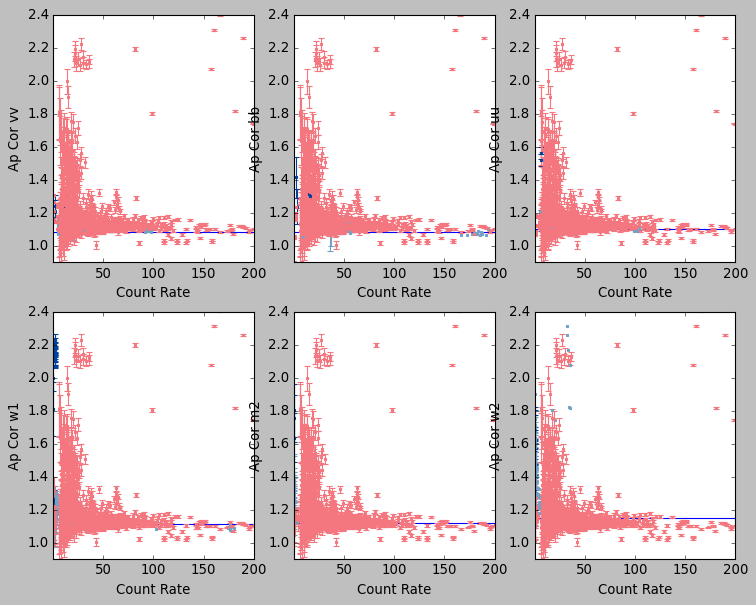

In [16]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcorflat[index],apcorflat[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Count Rate')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([0.1,200,0.9, 2.4])
    
    ax.plot([0.1,200],apcorline)
    #ax.plt.yscale("log")
    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            if "WD" in field: ax.errorbar(cr5[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            if "SN" in field: ax.errorbar(cr5[i,j,c,:], apcor[i,j,c,:], apcore[i,0,c,:] ,   marker='s', linestyle='none', mfc=colors[j],mec=colors[j], ms=2, mew=1, color=colors[j])

    ax.errorbar(cr5[bin<2]/cr5e[bin<2], apcor[bin<2], apcore[bin<2] ,   marker='s', linestyle='none', mfc=colors[2], mec=colors[2], ms=2, mew=1, color=colors[2])
        
plt.savefig('UVOTapcor_cr.png', dpi=300, bbox_inches='tight')
plt.show()